# Near-term Quantum Computing - Parametrized Circuits

**Instructor** : Hwajung Kang, Ph.D., Quantum Computational Scientist, IBM Quantum

In [10]:
from qiskit import *
from qiskit.result import sampled_expectation_value
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Statevector, random_unitary, partial_trace, hellinger_fidelity
from qiskit.visualization import plot_distribution
from qiskit.visualization.bloch import Bloch
from qiskit.circuit.library import XGate, YGate, ZGate, ZZFeatureMap, EfficientSU2

from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider

import numpy as np
import matplotlib.pyplot as plt
import time

import pandas as pd

## Impact of Noise

In [2]:
prov = IBMProvider()

In [3]:
backend = prov.get_backend('ibm_hanoi')

In [4]:
def myfunc(my_str):
    num_str = len(my_str)
    ind = num_str - 1 - np.where(np.array(list(my_str)) == '1')[0]
    qc = QuantumCircuit(num_str+1, name ='oracle')
    qc.cx(ind, num_str)
    U = qc.to_gate()
    return U

def BV(U):
    num_str = U.num_qubits - 1
    qc = QuantumCircuit(num_str + 1, num_str)
    qc.x(num_str)
    qc.h(range(num_str + 1))
    qc.barrier()
    qc.append(U, range(num_str+1))
    qc.barrier()
    qc.h(range(num_str))
    qc.measure(range(num_str), range(num_str))
    
    return qc

In [35]:
qc_all = []
for k in range(3, 10):
    U = myfunc('1'*k)
    qc_all.append(BV(U))
    
qc_all_trans = transpile(qc_all, backend, optimization_level=3)

In [36]:
job = backend.run(qc_all_trans, shots=100000)
print(job.job_id())

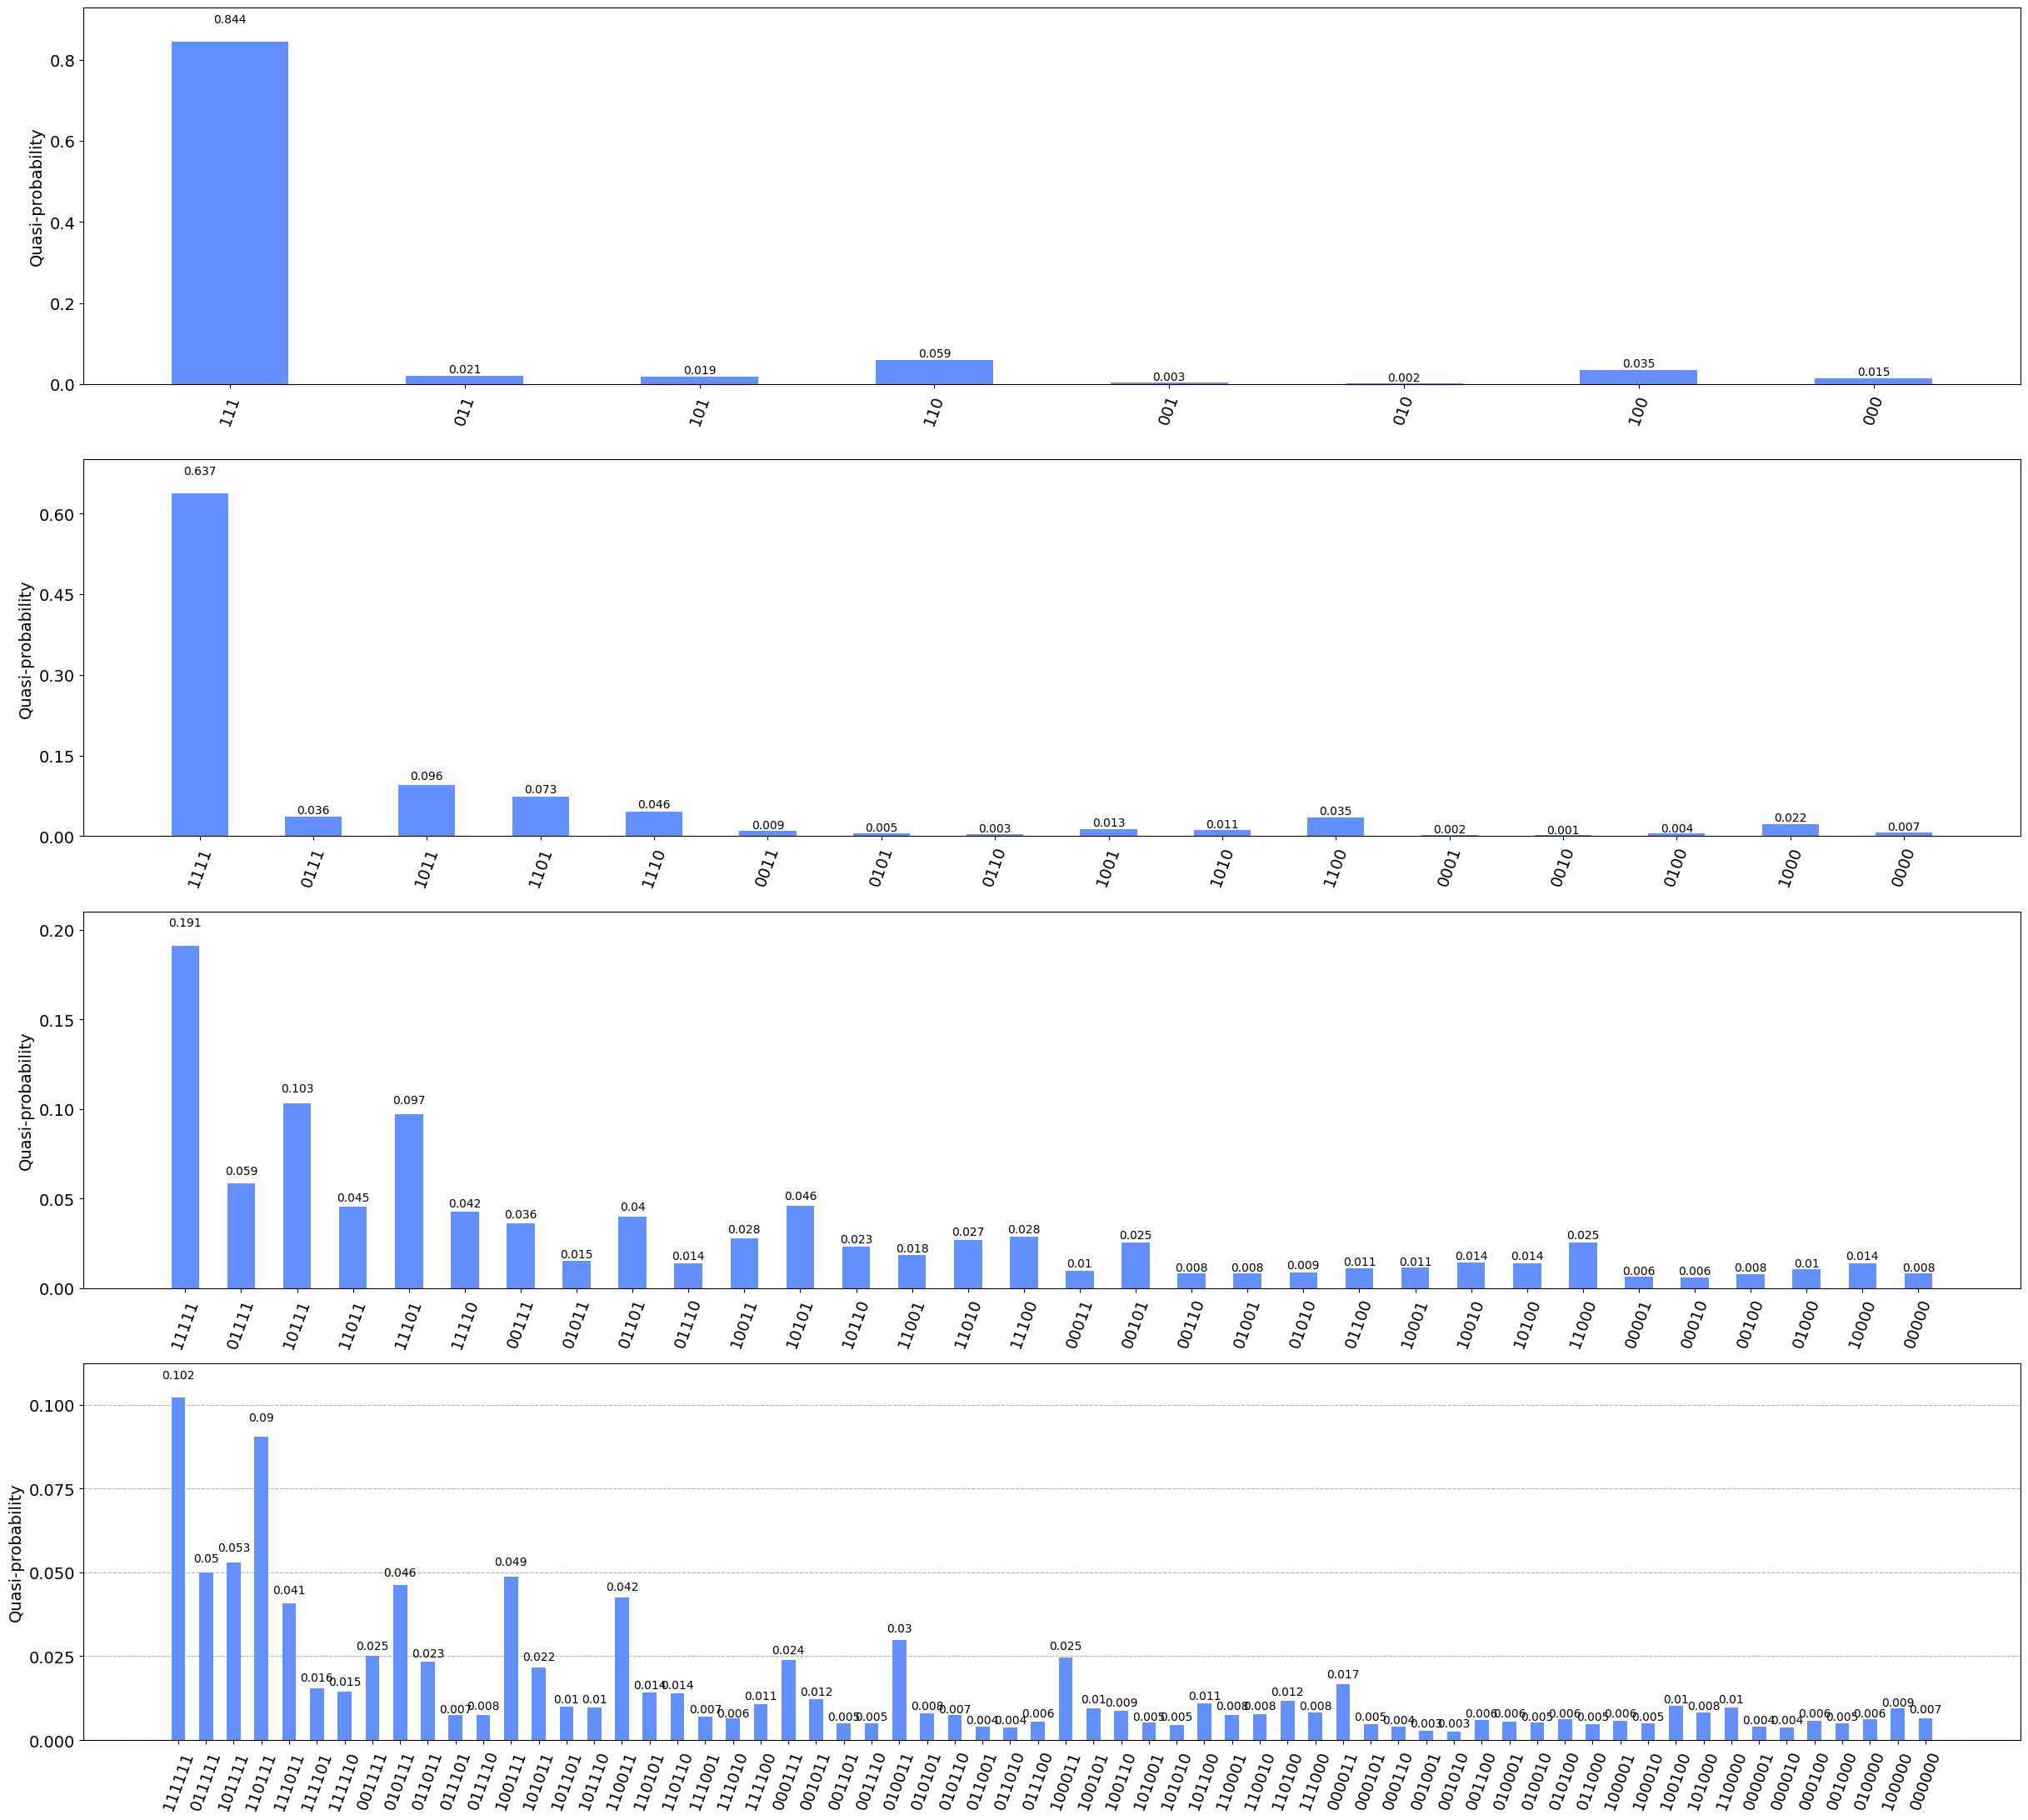

In [8]:
#job = prov.retrieve_job('cge84l9qf3dvb4ojjn60')
counts_all = job.result().get_counts()

fig, axs = plt.subplots(4, 1, figsize=(30, 27))
for k in range(4):
    plot_distribution(counts_all[k], ax=axs[k], target_string='1'*(3+k), sort='hamming')

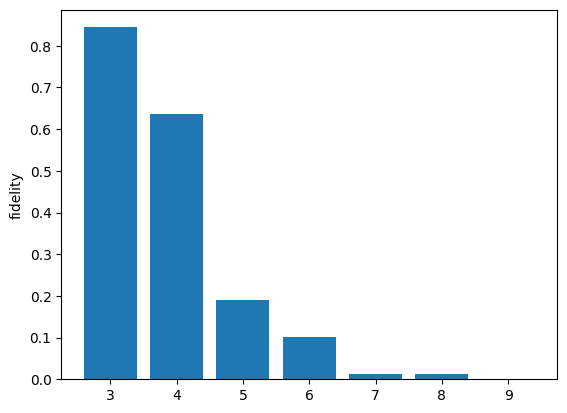

In [11]:
# hellinger_fidelity
counts_ideal = [{'1'*k:1} for k in range(3, 10)]

x = list(range(3, 3+len(counts_all)))
y = [hellinger_fidelity(counts_ideal[k], counts_all[k]) for k in range(len(counts_all))]

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_ylabel('fidelity');

## Parametrized circuit - Basics

<div class="alert alert-block alert-info">

**When to use?**
- The computation requires executing circuits with the same structure 

**Why to use?**
- No need to construct multiple circuits - build one circuit
- No need to transpile circuit multiple times - transpile circuit once
   
</div>

### Phase kickback

<div><img src="phase_kickback.png" width="600"/></div>

In [12]:
angles = np.linspace(0, 8*np.pi, 200)

In [13]:
backend = prov.get_backend('ibmq_lima')

- Without using parametrized circuit

In [14]:
start = time.time()

qc_all = []
for ang in angles:
    qc = QuantumCircuit(2, 1)
    qc.h(0)
    qc.x(1)
    qc.cp(ang, 0, 1)
    qc.h(0)
    qc.measure(0, 0)
    qc_all.append(qc)

qc_trans_all = transpile(qc_all, backend, optimization_level=3)

finish = time.time()
del_time1 = (finish - start)

/Users/hwajungkang/mambaforge/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/hwajungkang/mambaforge/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [15]:
print('transpile time : {}s'.format(np.round(del_time1, 3)))

transpile time : 1.592s


- Parametrized circuit version

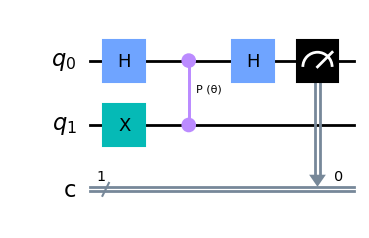

In [16]:
#Build a parametrized circuit

theta = Parameter(name='θ')

qc = QuantumCircuit(2, 1)
qc.h(0)
qc.x(1)
qc.cp(theta, 0, 1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

In [17]:
# Transpile parameterized circuit
start = time.time()

theta = Parameter(name='θ')

qc = QuantumCircuit(2, 1)
qc.h(0)
qc.x(1)
qc.cp(theta, 0, 1)
qc.h(0)
qc.measure(0, 0)

qc_trans = transpile(qc, backend, optimization_level=3)

qc_trans_all2 = []
for ang in angles:
    qc_trans_all2.append(qc_trans.bind_parameters({theta:ang}))
    
finish = time.time()
del_time2 = finish - start

/Users/hwajungkang/mambaforge/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/hwajungkang/mambaforge/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [18]:
print('transpile time : {}s'.format(np.round(del_time2, 3)))

transpile time : 0.023s


**Things to note**
- Benefit of parametrized circuits grows with the number of circuits, circuit complexity, and the size of the backend as the time it takes for transpilation grows polynomially with the circuit size
- As numerical parameter values are needed for many optimization steps, transpiling parameterized circuits may not yeild optimal results.

without parametrizing circuit


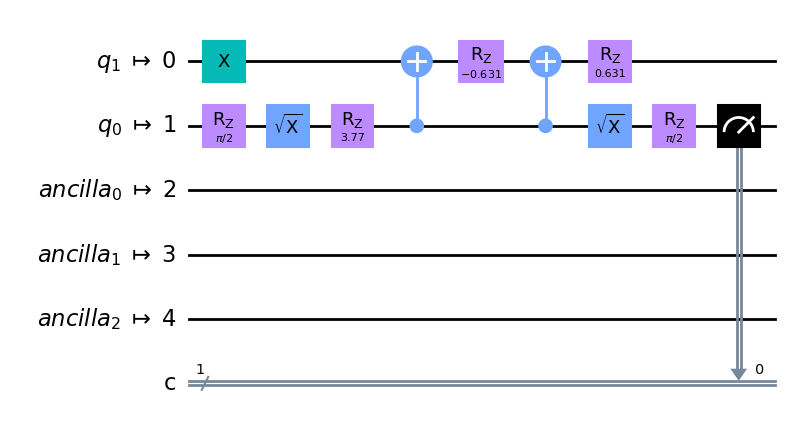

In [19]:
k = 10
print('without parametrizing circuit')
qc_trans_all[k].draw('mpl')

using parametrized circuit


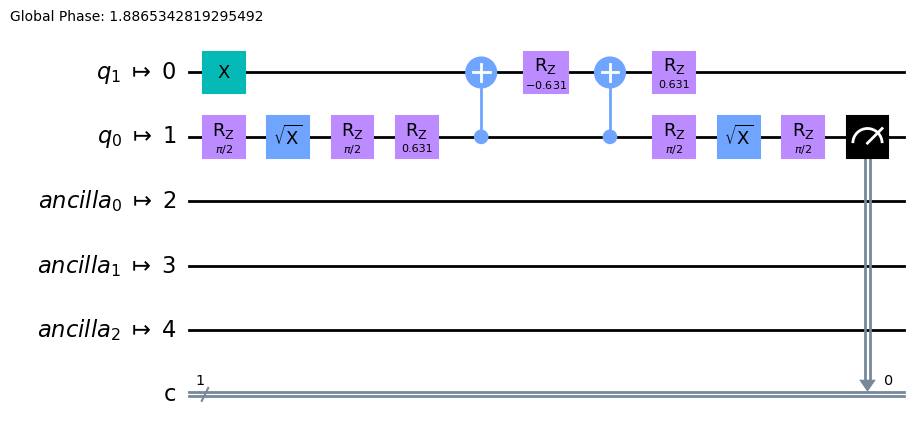

In [20]:
print('using parametrized circuit')
qc_trans_all2[k].draw('mpl')

## Build parametrized circuit

[u gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.U3Gate.html#qiskit.circuit.library.U3Gate)

### parameter

In [21]:
theta, gamma, lam = Parameter('θ'), Parameter('γ'), Parameter('λ') 
myqc1 = QuantumCircuit(1)
myqc1.u(theta, gamma, lam, 0)
print(myqc1)

myvals = [1, 2, 3]
#mybc1 = myqc1.bind_parameters({theta:1, gamma:2, lam:3})
mybc1 = myqc1.assign_parameters(myvals)
print(mybc1)

   ┌──────────┐
q: ┤ U(θ,γ,λ) ├
   └──────────┘
   ┌──────────┐
q: ┤ U(2,1,3) ├
   └──────────┘


Note: The parameter values are assigned in the alphabetical order rather than the insertion order when `assign_parameters` method is used.

### parameter vector

In [22]:
ang = ParameterVector('φ', 3)
myqc2 = QuantumCircuit(1) 
myqc2.u(*ang, 0)
print(myqc2)

mybc2 = myqc2.assign_parameters(myvals)
#mybc2 = myqc2.bind_parameters({ang:myvals})
print(mybc2)

   ┌───────────────────┐
q: ┤ U(φ[0],φ[1],φ[2]) ├
   └───────────────────┘
   ┌──────────┐
q: ┤ U(1,2,3) ├
   └──────────┘


### partial binding

In [23]:
theta, gamma, lam = Parameter('θ'), Parameter('γ'), Parameter('λ') 
myqc1 = QuantumCircuit(1)
myqc1.u(theta, gamma, lam, 0)
print(myqc1)

myvals = [1, 2, 3]
mybc1 = myqc1.bind_parameters({theta:1, gamma:2})
mybc2 = myqc1.bind_parameters({theta:3, gamma:4})

print(mybc1)

   ┌──────────┐
q: ┤ U(θ,γ,λ) ├
   └──────────┘
   ┌──────────┐
q: ┤ U(1,2,λ) ├
   └──────────┘


In [24]:
two_angs, one_ang = ParameterVector('δ', 2), Parameter('ε')
myqc3 = QuantumCircuit(1)
myqc3.u(*two_angs, one_ang, 0)
print(myqc3)

mybc3 = myqc3.bind_parameters({two_angs:[1, 2]})
print(mybc3)

   ┌────────────────┐
q: ┤ U(δ[0],δ[1],ε) ├
   └────────────────┘
   ┌──────────┐
q: ┤ U(1,2,ε) ├
   └──────────┘


<div class="alert alert-block alert-success">

### Hands-on exercise 1.

Build a five qubit quantum circuit where a `rx` gate with an unique parametrized angle is applied to each qubit. Then apply `cp` gates with different parametrized angles between the $k$th and $k$th+1 qubits.
Assign numerical values that you want only to `cp` gates.
    
</div>

In [25]:
## your code goes here














- Further reading: [Advanced Circuit](https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html)

## Usecase 1. Data Encoding - Quantum feature map for QSVM 

QSVM : Quantum Support Vector Machine
- Reference : [_Havlicek et al_.  Nature **567**, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2)

### 1-dim data

[2.85913664 4.90372456 0.56373525 1.45088063 1.79183378]


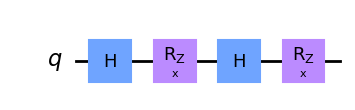

In [26]:
num = 500
data = 2 * np.pi * np.random.rand(num)
print(data[:5])

x = Parameter(name='x')
qc_data = QuantumCircuit(1)
qc_data.h(0)
qc_data.rz(x, 0)
qc_data.h(0)
qc_data.rz(x, 0)

qc_data.draw('mpl')

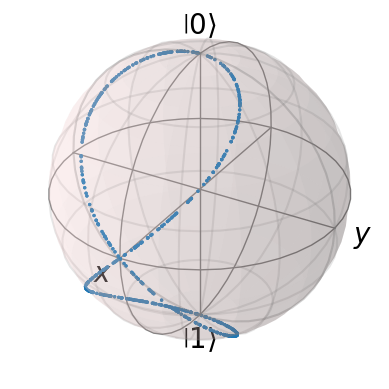

In [27]:
X, Y, Z = XGate(), YGate(), ZGate()
Xop, Yop, Zop = X.to_matrix(), Y.to_matrix(), Z.to_matrix()

def state_to_bloch(state_vec):
    phi = st.data
    bx = phi.conjugate() @ Xop @ phi
    by = phi.conjugate() @ Yop @ phi
    bz = phi.conjugate() @ Zop @ phi
    return [bx, by, bz]


st_data = [Statevector(qc_data.assign_parameters([dat]))for dat in data]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
b = Bloch(axes=ax)
b.point_color = ['tab:blue']
b.point_marker = ['o']
b.point_size =[2]

for st in st_data:
    v = state_to_bloch(st)
    b.add_points(v)
    
b.show()


### N-dim data 
- Check out **Data encoding circuits** in [Qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html)

**[ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)**

$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d,$$ 

where $$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}.$$
    
`ZZFeatureMap` is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None,
             parameter_prefix='x', insert_barriers=False)
```

In [28]:
data = 2 * np.pi * np.random.rand(5, 3)

df = pd.DataFrame(data)
df.rename(columns=dict(zip(df.columns, ['feat1', 'feat2', 'feat3'])))

,feat1,feat2,feat3
0,5.913989,6.088910,5.334361
1,4.222004,3.786799,1.814882
2,6.021185,2.604477,1.587011
3,3.881414,2.585051,5.419872
4,4.418514,4.469323,1.296984


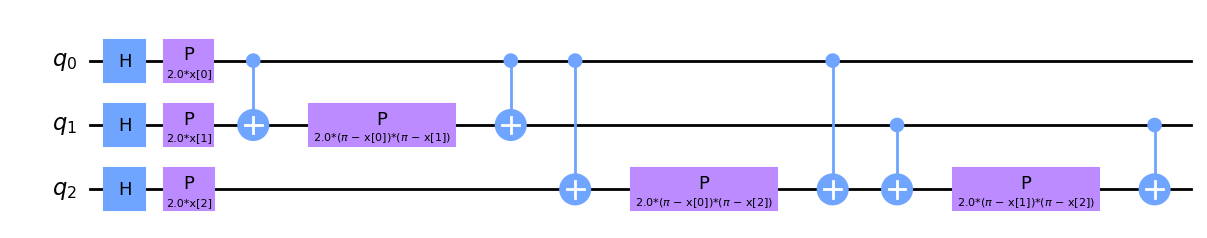

In [29]:
feat_map = ZZFeatureMap(3, reps=1)
feat_map.decompose().draw('mpl')

the number of quantum circuits : 5


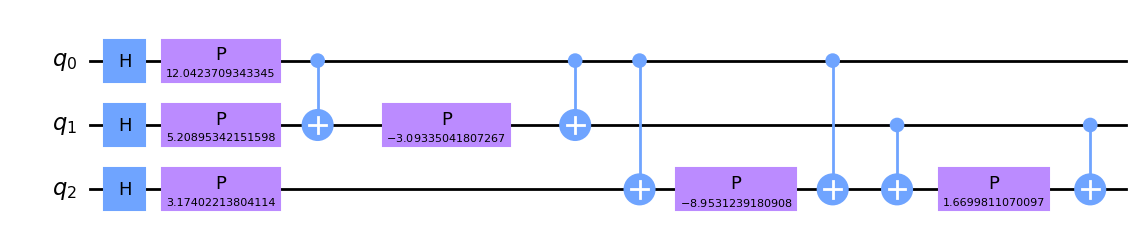

In [30]:
feat_map_data = [feat_map.assign_parameters(dat) for dat in data]
print('the number of quantum circuits : {}'.format(len(feat_map_data)))
feat_map_data[2].decompose().draw('mpl')

<div class="alert alert-block alert-success">

### Hands-on exercise 2.
Encode the following data, `data_ex`, using the `ZZFeatureMap` with 2 repetition. 
</div>

In [31]:
data_ex = 7*np.random.rand(10, 5)

df_ex = pd.DataFrame(data_ex)
df_ex.rename(columns=dict(zip(df_ex.columns,['feat1', 'feat2', 'feat3', 'feat4', 'feat5'])))

,feat1,feat2,feat3,feat4,feat5
0,6.719182,5.990631,6.321895,1.969520,3.144212
1,4.988070,4.017978,2.177310,5.238744,2.983170
2,3.305702,5.054904,4.131313,2.102953,2.815305
3,2.898779,0.960867,2.644468,3.281869,3.281469
4,1.271923,4.725965,5.225072,0.738959,5.409229
5,6.893688,5.228804,1.929088,3.896020,0.926722
6,4.778612,6.173565,5.619361,5.789791,6.022824
7,2.551707,4.810789,4.831358,2.604656,3.499406
8,3.375056,5.761539,3.586353,1.539643,0.484280
9,2.816789,0.424937,2.571416,1.230770,0.069337


In [32]:
## your code goes here










## Usecase 2. Ansatz preparation- VQA

VQA : Variational Quantum Algorithm

- Check out the section **N-local circuits** in [Qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html)

**[EfficientSU2](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html#qiskit.circuit.library.EfficientSU2)**

`EfficientSU2` is a parametrized quantum circuit generating a hardware efficient, heuristic ansatz with alternating rotation and entanglement layer, which is used for variational quantum algorithms or classification circuit for machine learning.

```python
EfficientSU2(num_qubits=None, su2_gates=None, entanglement='reverse_linear', 
             reps=3, skip_unentangled_qubits=False, 
             skip_final_rotation_layer=False, parameter_prefix='θ',
             insert_barriers=False, initial_state=None)
```

Check [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html#qiskit.circuit.library.TwoLocal) for entanglement strategies.

<div class="alert alert-block alert-success">

### Hands-on exercise 3.
Build a circuit to generate a hardware efficient ansatz for a 5 qubit system through `EfficientSU2` with 3 repetitions, using `h` and `rz` gates for `su2_gates`, implementing the `entangler_map` $= [[2, 1], ~ [1, 0], ~ [2, 3], ~[3, 4]]$.
    
</div>

In [33]:
## your code goes here







**Further Reading** 
- [Parametrized quantum circuits](https://learn.qiskit.org/course/machine-learning/parameterized-quantum-circuits#parameterized-1-0)

In [34]:
import qiskit.tools.jupyter 
%qiskit_version_table
%qiskit_copyright